# Solving optimization problems with `scipy`

Short (and incomplete) overview of techniques to solve non-linear optimization problems in `scipy`.

Author: Tobias Windisch (http://www.tobias-windisch.de)

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

In [2]:
def plot_constrains():
    fig = plt.figure(figsize=(20, 5))
    ax_eq = fig.add_subplot(131, projection='3d')
    ax_ineq = fig.add_subplot(132, projection='3d')
    ax_objective = fig.add_subplot(133, projection='3d')
    ax_objective.set_title('Objective $f$')

    # Equality constrain
    x0 = np.arange(-1.5, 1.5, 0.25)
    x1 = np.arange(-1.5, 1.5, 0.25)
    X0, X1 = np.meshgrid(x0, x1)
    X2 = -np.sin(3*(X0 + X1))
    ax_eq.plot_surface(X0, X1, X2, color='red', alpha=0.5)
    ax_eq.set_title("Equality constrain $h$")

    # Inequality constrain
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax_ineq.plot_surface(x, y, z, alpha=0.5, color='red')
    ax_ineq.set_title('Inequality constrain $g$')
    
    # Objective
    x0 = np.arange(-1.5, 1.5, 0.25)
    x1 = np.arange(-1.5, 1.5, 0.25)
    x2 = np.arange(-1.5, 1.5, 0.25)

    X0, X1, X2 = np.meshgrid(x0, x1, x2)  
    y = 2*X0.ravel() - X1.ravel()**3 +5*X2.ravel()
    # Visualize -f so that minimal regions are red
    ax_objective.scatter(X0.ravel(), X1.ravel(), X2.ravel(), c=-y, cmap=cm.coolwarm)
    
    for ax in [ax_ineq, ax_eq, ax_objective]:
        ax.set_xlabel('X0')
        ax.set_ylabel('X1')
        ax.set_zlabel('X2')
        
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.5, 1.5])
        
    fig.tight_layout()
    return ax_eq, ax_ineq, ax_objective


## Optimization in one dimension

Find minimum of $f(x)=x\cdot \sin(x^2)-\exp(-x)$ within $[0, 3]$

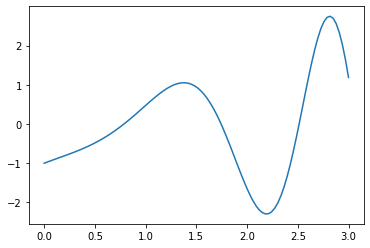

In [3]:
fig, ax = plt.subplots()
x = np.linspace(0, 3, 100)
y = x*np.sin(x**2) -np.exp(-x)
ax.plot(x, y)

**(high school) Approach:**
    
* Compute first derivative $f'$
* Compute roots of first derivatives $f''$
* Evaluate second derivatives at roots
* Don`t forget to check the boundaries $0$ and $3$


# What is an optimization problem?


Given a $f, g_1,\ldots, g_m, h_1, h_m: \mathbb{R}^d\to\mathbb{R}$

$$\min f(x)$$

such that

$$g_i(x)\ge 0 \forall i\in[m|$$ 

$$h_i(x)= 0 \forall i\in[p|$$

* $f$: objectibve
* $g_i$: Soft constraints
* $h_i$: Hard constraints


## Challenges


As always: More dimensions, more fun!

Things that become (a lot) harder in more dimensions:
* Derivatives (Jacobian vector) are vector functions now, computing roots is hard
* Second order derivatives are matrices (Hessian matrix) and are often impossible to compute
* Constraints are much more than intervals and can be arbitrarily complex

### More problems
* Integer programming: Replace $\mathbb{R}$ with $\mathbb{Z}$
* Combinatorial optimization: Subdiscipine of Integer programming, mostly involving graphs (like shortest route problems)
* Stochastic optimization: Optimize expected values of random variables


## Running example

* $f(x)= 2\cdot x_0 - x_1^3 +5\cdot x_2$ (to be minimized)
* $g(x) = x_0^2+x_1^2+x_2^2 -1$ (must be greater than zero)
* $h(x) = \sin(3\cdot (x_0+x_1)) + x_2-1$ (must be equal to zero)

(<Axes3DSubplot:title={'center':'Equality constrain $h$'}, xlabel='X0', ylabel='X1'>,
 <Axes3DSubplot:title={'center':'Inequality constrain $g$'}, xlabel='X0', ylabel='X1'>,
 <Axes3DSubplot:title={'center':'Objective $f$'}, xlabel='X0', ylabel='X1'>)

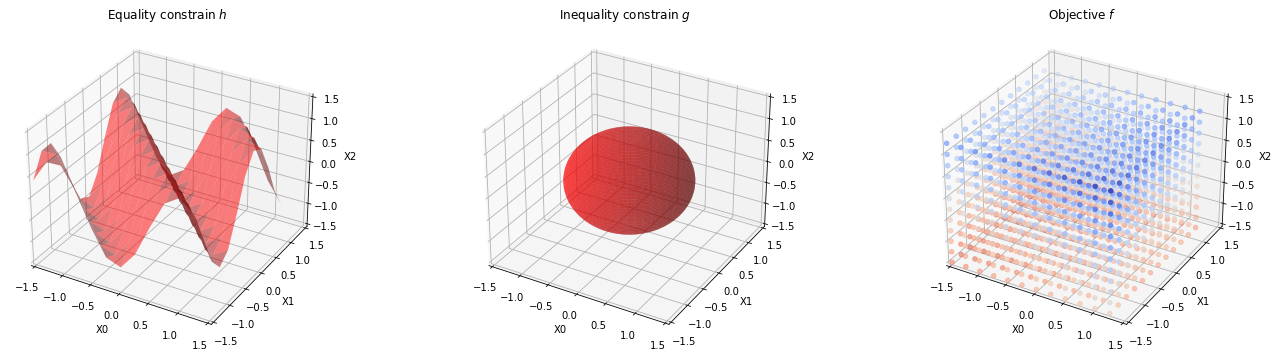

In [4]:
plot_constrains()

# How to solve it?

Underlying principle: Use iterative algorithm of the form

$$ x_{k+1}=x_{k}+\alpha_k\cdot u_k$$

## Special cases

### Linear programmng

$f(x)=w^Tx$ is a linear function, $g$ and $h$ affine functions. Optimum lies on edges of feasible region

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Linear_optimization_in_a_2-dimensional_polytope.svg/1920px-Linear_optimization_in_a_2-dimensional_polytope.svg.png" width=100>

* Simplex method: Walks edges of feasible region (which is a polytope). Best practical performance to solve linear optimization problems
<img src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Simplex-method-3-dimensions.png" width=100>

* Interior point method: Walks straight through the polytope. Best theoretical performance

### Quadratic programming
$f(x)=\frac{1}{2}x^TAx + c^Tx$ quadratic, $g_i$'s and $h_i$'s affine. Hardness of problem depends a lot on $A$ (if $A$ positive definite, solvable in polynomial time, otherwise NP-hard)

* **Conjugate gradient method**: Finds solution to $Ax=c$ for symmetric and positive-definite $A$. As $\nabla f(x)=Ax +c$ (in quadratic function, $A$ can always be chosen symmetric) and hence finds global minimum. 

### Unconstrained
No $h_i$'s, no $g_i$'s 

Generally: No guarantee to find **global** minimum. Most algorithms aim for point where $\nabla f(x)=0$

* **Newton-Method**: Needs first and second order derivatives

$$ x_{k+1}=x_{k}-H_f^{-1}(x_{k})\nabla f(x_{k})$$

* **Quasi-Newton Methods**: Newton-Method that uses approximation of inverse of hessian matrix $H_f$:

$$ x_{k+1}=x_{k}-\alpha_{k}M(x_{k})\nabla f(x_{k})$$

* **Conjugate-gradient method**: If $f$ is linear or quadratic
* **BFGS** and **L-BFGS**: Quasi-Netwon method that approximate hessian matrix, commonly used in praxis. (Fun fact: BFGS appeard was developed by four researchers independently


### Only hard constrains

No $g_i$'s: Can be reformulated using [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier) to and unconstrained optimization problem



### Optimization problem of machine learning

In machine learning, the objective often has the form

$$f(w) = \sum_{i=1}^n L(m(x_i, w), y)$$


* As $n$ is large, even $\nabla_w f$ cannot be computed and hence even the first-order information is not available. Stochastic gradients try to approximate 
$$\nabla_w f(w)\cong \sum_{j=1}^k\nabla L(m(x_i, w), y)$$ 
by subsampling components of $f$ (that is, using batches of $\{(x_i, y_i): i\in[n]\}$. 
* For $m(\cdot ,w)$ a neural network, even $\nabla_w L(m(x_i, w), y)$ cannot be computed in general for all $w$ and needs to be compouted using automatic differenciation (here: backpropagation)


**Remark**: The models `sklearn.neural_network.MLPRegressor` can be solved with stochastic gradients (like with Adam) or using Newton methods when `solver=lbfgs` is plugged in (of course, only works with "not-so-much" data).

## General case


Most methods make use of [KKT-Conditions](https://en.wikipedia.org/wiki/Karush–Kuhn–Tucker_conditions) (a generalization of Lagrange multipliers) which require to find a saddle point of


$$L(x, \mu, \lambda):=f(x) - \mu^T\cdot(g_1(x), \ldots, g_m(x)) - \lambda^T\cdot(h_1(x),\ldots, h_p(x))$$


#### Sequential least square programming

Iterative algorithm which computes in every step a search direction $d_k$  as solution to the quadratic optimization problem:

$$\min_{d}  \nabla f(x_k)^Td + \tfrac{1}{2} d^T \nabla_{xx}^2 \mathcal{L}(x_k,\mu_k,\lambda_k) d$$ 

such that 
$$g_i(x_k) + \nabla g_i(x_k)^T d\ge 0$$
$$h_i(x_k) + \nabla h_i(x_k)^T d = 0$$
  
  

Then $x_{k+1} = x_k + d_k$

#### Trust region method
Iterative algorithm which compues in every step a search direction $d_k$ as solution to the quadratic optimization problem coming from a second-order Taylor approximation of $f$:


$$\min_{d}  \nabla f(x_k)^Td + \tfrac{1}{2} d^T \nabla_{xx}^2 \mathcal{f}(x_k) d$$ 

such that $\|d\|\le \Delta_k$, where $\Delta_k$ is the trust-region radius

<img src="https://optimization.mccormick.northwestern.edu/images/e/e4/Trust-Region_Method_Overview.png" width=300>



## `scipy`

aka, the de-facto standard for scientific python.

Module of interest is `scipy.optimize` (which has a well-written [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html))

In [5]:
from scipy.optimize import minimize

In [6]:
def f(x):
    return 2*x[0] - x[1]**3 +5*x[2] 

def df(x):
    return np.array([
        2, 
        -3*x[1]**2, 
        5])

def ddf(x):
    return np.array([
        [0, 0, 0],
        [0, -6*x[1], 0],
        [0, 0, 0],
    ])

def g(x):
    return 1-(x[0]**2 + x[1]**2 + x[2]**2)

def dg(x):
    return np.array([
        -2*x[0], 
        -2*x[1], 
        -2*x[2]]
    )

def h(x):
    return np.sin(3*(x[0]+ x[1])) + x[2]

def dh(x):
    return np.array([
        3*np.cos(3*(x[0]+ x[1])),
        3*np.cos(3*(x[0]+ x[1])),
        1
    ])

In [7]:
result = minimize(
    fun=f,
    jac=df,
    hess=ddf,
    # Starting with feasible point is not mandatory, but improves result
    x0=np.array([0, 0 , 0]),
    method='SLSQP',
    options={
        "maxiter": 100000
    },
    constraints=[
        {
            "type": "ineq",
            "fun": g,
            "jac": dg
        },
        {
            "type": "eq",
            "fun": h,
            "jac": dh
        },
    ]
)

/Users/windisch/opt/miniconda3/envs/profitarea/lib/python3.8/site-packages/scipy/optimize/_minimize.py:524: RuntimeWarning: Method SLSQP does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


In [8]:
result

     fun: -3.7757427648477773
     jac: array([ 2.        , -0.56923284,  5.        ])
 message: 'Optimization terminated successfully'
    nfev: 17
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-0.77201323, -0.43559572, -0.46287356])

In [9]:
f(result.x)

-3.7757427648477773

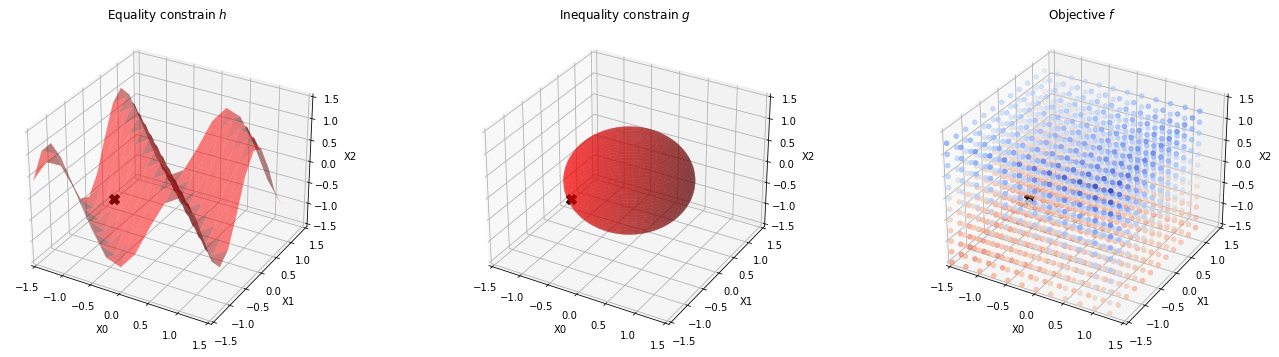

In [10]:
axes = plot_constrains()

for ax in axes:
    ax.scatter(result.x[0], result.x[1], result.x[2], color='black', marker='X', s=100)

### Changing start point
Influence of start point is imense. Non-feasible points may lead to better results!

In [11]:
result = minimize(
    fun=f,
    jac=df,
    hess=ddf,
    x0=np.array([-1, 1 , 0]),
    method='SLSQP',
    options={
        "maxiter": 100000
    },
    constraints=[
        {
            "type": "ineq",
            "fun": g,
            "jac": dg
        },
        {
            "type": "eq",
            "fun": h,
            "jac": dh
        },
    ]
)

In [12]:
result

     fun: -4.709177452326062
     jac: array([ 2.        , -0.66311474,  5.        ])
 message: 'Optimization terminated successfully'
    nfev: 14
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([-0.11495361,  0.47014705, -0.87506995])

In [13]:
f(result.x)

-4.709177452326062

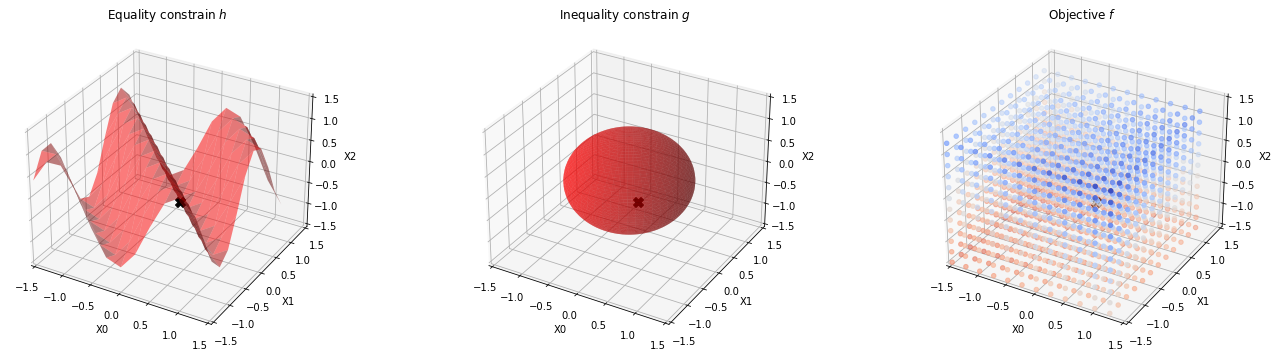

In [14]:
axes = plot_constrains()

for ax in axes:
    ax.scatter(result.x[0], result.x[1], result.x[2], color='black', marker='X', s=100)

## Trust region

In [15]:
from scipy.optimize import NonlinearConstraint

In [16]:
const_ineq = NonlinearConstraint(
    fun=g,
    jac=dg,
    lb=0,
    ub=np.inf)

const_eq = NonlinearConstraint(
    fun=h,
    jac=dh,
    lb=0,
    ub=0)

In [17]:
result = minimize(
    fun=f,
    jac=df,
    hess=ddf,
    x0=np.array([0, 0 , 0]),
    method='trust-constr',
    tol=0.0001,
    options={
        "maxiter": 100000
    },
    # Completely different API call
    constraints=[const_ineq, const_eq]
)

In [18]:
result.x

array([ 0.1989698 ,  0.52235532, -0.82916779])

In [19]:
f(result.x)

-3.890426646704483

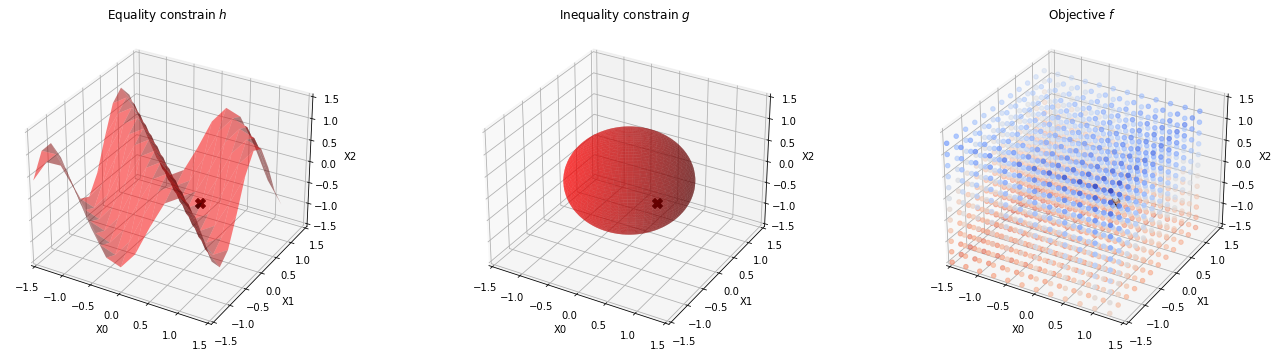

In [20]:
axes = plot_constrains()

for ax in axes:
    ax.scatter(result.x[0], result.x[1], result.x[2], color='black', marker='X', s=100)